In [ ]:
# import modules

import zarr
import xarray as xr
import matplotlib.pyplot as plt
import gzip
import pickle
import numpy as np

In [ ]:
%matplotlib notebook

# latitude and longitude index for the box of interest
lat1=14
lat2=18
lon1=36
lon2=40

common=xr.open_zarr("/home/scratch/Abel_data/long_run2/common",consolidated=False)
lat=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
print(lat)

# compute temperature time series in the box, find mean and 95 percentile threshold
st=0
temp_field=0
for i in range(1,51):
    for j in range(1,21):
        D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
        if st==0:
            temp_field=D['air_temperature'][:,0].sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
            st=1
        elif st==1:
            temp_field = np.concatenate((temp_field,
                                         D['air_temperature'][:,0].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))), axis=0)

mean=np.mean(temp_field, axis=0)

obs=(temp_field*np.cos(lat)).sum(axis=(1,2))/(np.cos(lat).sum())
obs70=np.quantile(obs,0.95)
obs95=np.quantile(obs,0.95)
mean=np.mean(obs)
# print(mean)
# print(obs95-mean)
# print(obs70,obs95)

heat_count=0
heat_index=[]

# code to find heatwaves across the 1000 years using the 95 percentile threshold
# heatwaves are episodes where T95 is exceeded 3 days in a row
# the days just before and after a heatwave are also included
# as the data is daily frequency, linear interplotation is done to compute the exact (sub-daily) duration of the heatwave
for i in range(1,51):
    for j in range(1,21):

        D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
        temp_field=D['air_temperature'][:,0].sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
        obs=(temp_field*np.cos(lat)).sum(axis=(1,2))/(np.cos(lat).sum())

        ind=[]
        l=0
        ind_curr=[]
        int_heat=[]

        for k in range(365):

            if obs[k]>obs70:
                if len(ind_curr)==0:
                    ind_curr.append(k-1)
                    int_heat.append(obs[k-1])
                ind_curr.append(k)
                int_heat.append(obs[k])
                if obs[k]>obs95:
                    l=l+1
                else:
                    if l<3:
                        l=0

            else:
                if l>=3:
                    ind_curr.append(k)
                    int_heat.append(obs[k])

                    heat=np.array(int_heat)-obs95
                    st=1-heat[0]/(heat[0]-heat[1]); end=heat[-2]/(heat[-2]-heat[-1])
                    heat[0]=0;heat[-1]=0
                    dur_weight=np.ones(len(heat)-1); dur_weight[0]=st;dur_weight[-1]=end
                    time_arr=np.insert(dur_weight.cumsum(),0,0)
                    intensity=np.average((heat[1:]+heat[:-1])/2,weights=dur_weight)
                    mx=np.max(heat[1:-1])
                    dur=len(heat[1:-1])-1+st+end

                    if dur>=3:
                        heat_index.append([i,j,ind_curr,intensity,dur,mx,int_heat, st,end])
                        heat_count=heat_count+1


                l=0
                ind_curr=[]
                int_heat=[]

print(heat_count)

# save to a suitable location somewhere - set path
with gzip.open(path+'heat_indexv1', 'wb') as f:
    pickle.dump(heat_index, f)

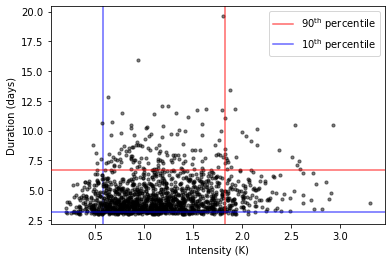

In [ ]:
# code to plot intensity-duration scatter of heatwaves

import seaborn as sns
import scipy.stats
from scipy import interpolate

# load from the same path
with gzip.open(path+'heat_indexv1', 'rb') as f:
    heat_index= pickle.load(f)

int_list=[]
dur_list=[]

for i in range(len(heat_index)):
    int_list.append(heat_index[i][3])
    dur_list.append(heat_index[i][4])

pni,pmi=np.quantile(int_list,[0.1,0.9])
plt.axvline(pni,color='blue',alpha=0.6, zorder=1)
plt.axvline(pmi,color='red',alpha=0.6, label=r'90$^{\mathrm{th}}$ percentile', zorder=2)
pnd,pmd=np.quantile(dur_list,[0.1,0.9])
plt.axhline(pnd,color='blue',alpha=0.6, label=r'10$^{\mathrm{th}}$ percentile', zorder=3)
plt.axhline(pmd,color='red',alpha=0.6, zorder=4)

plt.scatter(int_list, dur_list,s=10,color='black', alpha=0.5)

plt.xlabel('Intensity (K)')
plt.ylabel('Duration (days)')
plt.legend()